Michael Woodburn

This code is an implementation of a Long-Short Term Memory, a special kind of RNN, which is designed to forecast time series.

By running the code on timeseries which capture the number of confirmed cases of coronavirus in each country vs time, I'm seeking to train it to predict the next 3 days of coronavirus cases.

Given the limited accuracy of the LSTM for this data, I decided to test it on the last three known values (up to the 13th of March) which were witheld during training.

It achieved modest accuracy.

# Corona Virus

* Coronaviruses are **zoonotic** viruses (means transmitted between animals and people).  
* Symptoms include from fever, cough, respiratory symptoms, and breathing difficulties. 
* In severe cases, it can cause pneumonia, severe acute respiratory syndrome (SARS), kidney failure and even death.
* Coronaviruses are also asymptomatic, means a person can be a carrier for the infection but experiences no symptoms

# Novel coronavirus (nCoV)
* A **novel coronavirus (nCoV)** is a new strain that has not been previously identified in humans.

# COVID-19 (Corona Virus Disease 2019)
* Caused by a **SARS-COV-2** corona virus.  
* First identified in **Wuhan, Hubei, China**. Earliest reported symptoms reported in **November 2019**. 
* First cases were linked to contact with the Huanan Seafood Wholesale Market, which sold live animals. 
* On 30 January the WHO declared the outbreak to be a Public Health Emergency of International Concern 

# Acknowledgements

> https://github.com/CSSEGISandData/COVID-19

# Collection methodology

> https://github.com/imdevskp/covid_19_jhu_data_web_scrap_and_cleaning

# Libraries

### Install

### Import

In [28]:
# essential libraries
import json
import random
from urllib.request import urlopen

# storing and anaysis
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
import calmap
import folium

# color pallette
cnf = '#393e46' # confirmed - grey
dth = '#ff2e63' # death - red
rec = '#21bf73' # recovered - cyan
act = '#fe9801' # active case - yellow

# converter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()   

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# html embedding
from IPython.display import Javascript
from IPython.core.display import display
from IPython.core.display import HTML

In [22]:
%matplotlib inline

# Dataset

In [ ]:
# list files
# !ls ../input/corona-virus-report

In [3]:
# importing datasets
full_table = pd.read_csv('input/covid_19_clean_complete.csv', 
                         parse_dates=['Date'])
full_table.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Thailand,15.0000,101.0000,2020-01-22,2,0,0
1,NaN,Japan,36.0000,138.0000,2020-01-22,2,0,0
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0,0,0
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0,0,0
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0,0,0


In [5]:
#dataframe info
full_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11960 entries, 0 to 11959
Data columns (total 8 columns):
Province/State    5876 non-null object
Country/Region    11960 non-null object
Lat               11960 non-null float64
Long              11960 non-null float64
Date              11960 non-null datetime64[ns]
Confirmed         11960 non-null int64
Deaths            11960 non-null int64
Recovered         11960 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 747.6+ KB


In [6]:
# checking for missing value
full_table.isna().sum()

Province/State    6084
Country/Region       0
Lat                  0
Long                 0
Date                 0
Confirmed            0
Deaths               0
Recovered            0
dtype: int64

# Preprocessing

### Cleaning Data

In [7]:
# cases 
cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']

# Active Case = confirmed - deaths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']

# replacing Mainland china with just China
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')

# filling missing values 
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
full_table[cases] = full_table[cases].fillna(0)

In [31]:
full_table.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
0,,Thailand,15.0000,101.0000,2020-01-22,2,0,0,2
1,,Japan,36.0000,138.0000,2020-01-22,2,0,0,2
2,,Singapore,1.2833,103.8333,2020-01-22,0,0,0,0
3,,Nepal,28.1667,84.2500,2020-01-22,0,0,0,0
4,,Malaysia,2.5000,112.5000,2020-01-22,0,0,0,0


I want to create a predictive model which forecasts the number of cases at each lattitude on a given day.

In [32]:
'The input will be in the shape of a globe'

#Total width encompasses all longitudes
#Total height encompasses all lattitudes

input_width = 360
input_height = 180

In [ ]:
'The target will be a similar shape'

It may be of more use to train a time series LSTM to predict the number of cases in each country.

In [68]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [41]:
Confirmed_Time = full_table.groupby(['Date', 'Country/Region'])['Confirmed'].sum()
Confirmed_Time = Confirmed_Time.reset_index().sort_values(by=['Date', 'Country/Region'])

In [106]:
series_list = []
series_dict = {}

i = 0
for CountryRegion in Confirmed_Time['Country/Region'].unique():
    series_dict[i] = CountryRegion
    series = Confirmed_Time[Confirmed_Time['Country/Region']==CountryRegion][['Date','Confirmed']]
    series.rename(columns={"Date": "ds",'Confirmed':'y'},inplace=True)
    series_list.append(series)
    i+=1

In [ ]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size

        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)

        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)

        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

In [ ]:
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [107]:
# In this section I instantiate and train a new model for each individual country. The model has no ability to transfer it's learning from one country to another.

preds_all = []

C_i = 0
for df in series_list:
    # Extract values from the source .csv file
    y = df['y'].values.astype(float)

    # Define a test size
    test_size = 3

    # Create train and test sets
    train_set = y[:-test_size]
    test_set = y[-test_size:]

    

    # Instantiate a scaler with a feature range from -1 to 1
    scaler = MinMaxScaler(feature_range=(-1, 1))

    train_norm = scaler.fit_transform(train_set.reshape(-1, 1))


    # Convert train_norm from an array to a tensor
    train_norm = torch.FloatTensor(train_norm).view(-1)

    # Define a window size
    window_size = 5

    # Define function to create seq/label tuples


    # Apply the input_data function to train_norm
    train_data = input_data(train_norm,window_size)



    torch.manual_seed(101)
    model = LSTMnetwork()

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    epochs = 50

    import time
    start_time = time.time()

    for epoch in range(epochs):

        # extract the sequence & label from the training data
        for seq, y_train in train_data:

            # reset the parameters and hidden states
            optimizer.zero_grad()
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))

            y_pred = model(seq)

            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()

        # print training result
    

    

    future = 3

    # Add the last window of training values to the list of predictions
    preds = train_norm[-window_size:].tolist()

    # Set the model to evaluation mode
    model.eval()

    for i in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())

    preds[window_size:] 

    true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
    print('for country ', series_dict[C_i])
    print('preds are ', true_predictions)
    print('actual values are ', test_set)
    preds_all.append((test_set,true_predictions))
    C_i+=1


for country  Afghanistan
preds are  [[ 6.86801046]
 [ 9.83349919]
 [13.68136764]]
actual values are  [7. 7. 7.]
for country  Albania
preds are  [[3.21910724]
 [0.78751504]
 [0.62446356]]
actual values are  [12. 23. 33.]
for country  Algeria
preds are  [[20.55295825]
 [20.48664808]
 [20.75558543]]
actual values are  [20. 24. 26.]
for country  Andorra
preds are  [[0.97956586]
 [0.96728316]
 [0.95452768]]
actual values are  [1. 1. 1.]
for country  Antigua and Barbuda
preds are  [[0.]
 [0.]
 [0.]]
actual values are  [0. 0. 1.]
for country  Argentina
preds are  [[21.91103989]
 [27.22518849]
 [32.50442863]]
actual values are  [19. 19. 31.]
for country  Armenia
preds are  [[0.99512681]
 [0.99219128]
 [0.98910758]]
actual values are  [1. 4. 8.]
for country  Aruba
preds are  [[0.]
 [0.]
 [0.]]
actual values are  [0. 0. 2.]
for country  Australia
preds are  [[112.16253525]
 [126.44870406]
 [142.0140667 ]]
actual values are  [128. 128. 200.]
for country  Austria
preds are  [[245.04276466]
 [300.6

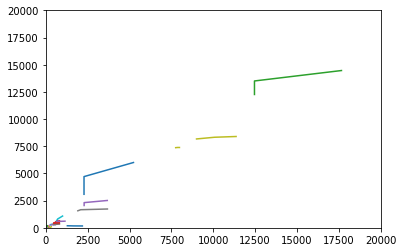

In [117]:
for pred in preds_all:
    x = pred[0]
    y = pred[1]
    plt.plot(x,y)
plt.xlim(-5, 20000)
plt.ylim(-5, 20000)
plt.show()

We can see that in general, there is a correlation between the number of cases and the number of cases predicted. Let's see what the R2 value is.

In [123]:
import itertools
a = [pred[0] for pred in preds_all]
b = [pred[1] for pred in preds_all]
x = list(itertools.chain.from_iterable(a))
y = list(itertools.chain.from_iterable(b))


In [128]:
from sklearn.metrics import r2_score

In [130]:
print('r2 score is ', r2_score(x,y))

r2 score is  0.9977242352207297


So our R2 score for our predictions is excellent. It's unclear how much importance we should place on this number, as I have not concluded yet that R2 score is appropriate for predicting time series.

In [131]:
from sklearn.metrics import mean_squared_error

In [132]:
print('RMSE score is ', mean_squared_error(x,y))

RMSE score is  124108.55687723232


The RMSE is a better metric but it is not scale-invariant. So any errors on the China values will throw off the whole thing by a lot. Let's try MAPE

In [133]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [134]:
mean_absolute_percentage_error(x,y)

nan

MAPE does not work here because there are so many 0 values.

Now I want to try again, but this time I won't re-instatiate the model each time I train it on a new country's data.
I will, however, allow the model to scale each country's input data. This is somewhat appropriate only in this case because epidemiological data can often be scale-invariant.

In [142]:
preds_all = []

model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [143]:
C_i = 0

for df in series_list:
    # Extract values from the source .csv file
    y = df['y'].values.astype(float)

    # Define a test size
    test_size = 3

    # Create train and test sets
    train_set = y[:-test_size]
    test_set = y[-test_size:]

    # Instantiate a scaler with a feature range from -1 to 1
    scaler = MinMaxScaler(feature_range=(-1, 1))

    train_norm = scaler.fit_transform(train_set.reshape(-1, 1))


    # Convert train_norm from an array to a tensor
    train_norm = torch.FloatTensor(train_norm).view(-1)

    # Define a window size
    window_size = 5

    # Define function to create seq/label tuples


    # Apply the input_data function to train_norm
    train_data = input_data(train_norm,window_size)



    torch.manual_seed(101)


    epochs = 50

    import time
    start_time = time.time()

    for epoch in range(epochs):

        # extract the sequence & label from the training data
        for seq, y_train in train_data:

            # reset the parameters and hidden states
            optimizer.zero_grad()
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))

            y_pred = model(seq)

            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()

    # print training result
    
    print('trained ', series_dict[C_i])
    C_i+=1

trained  Afghanistan
trained  Albania
trained  Algeria
trained  Andorra
trained  Antigua and Barbuda
trained  Argentina
trained  Armenia
trained  Aruba
trained  Australia
trained  Austria
trained  Azerbaijan
trained  Bahrain
trained  Bangladesh
trained  Belarus
trained  Belgium
trained  Bhutan
trained  Bolivia
trained  Bosnia and Herzegovina
trained  Brazil
trained  Brunei
trained  Bulgaria
trained  Burkina Faso
trained  Cambodia
trained  Cameroon
trained  Canada
trained  Cayman Islands
trained  Chile
trained  China
trained  Colombia
trained  Congo (Kinshasa)
trained  Costa Rica
trained  Cote d'Ivoire
trained  Croatia
trained  Cruise Ship
trained  Cuba
trained  Cyprus
trained  Czechia
trained  Denmark
trained  Dominican Republic
trained  Ecuador
trained  Egypt
trained  Estonia
trained  Ethiopia
trained  Finland
trained  France
trained  French Guiana
trained  Georgia
trained  Germany
trained  Greece
trained  Guadeloupe
trained  Guinea
trained  Guyana
trained  Holy See
trained  Honduras


In [145]:
C_i = 0
for df in series_list:
    # Extract values from the source .csv file
    y = df['y'].values.astype(float)

    # Define a test size
    test_size = 3

    # Create train and test sets
    train_set = y[:-test_size]
    test_set = y[-test_size:]

    

    # Instantiate a scaler with a feature range from -1 to 1
    scaler = MinMaxScaler(feature_range=(-1, 1))

    train_norm = scaler.fit_transform(train_set.reshape(-1, 1))


    # Convert train_norm from an array to a tensor
    train_norm = torch.FloatTensor(train_norm).view(-1)

    # Define a window size
    window_size = 5


    future = 3

    # Add the last window of training values to the list of predictions
    preds = train_norm[-window_size:].tolist()

    # Set the model to evaluation mode
    model.eval()

    for i in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())

    preds[window_size:] 

    true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
    print('for country ', series_dict[C_i])
    print('preds are ', true_predictions)
    print('actual values are ', test_set)
    preds_all.append((test_set,true_predictions))
    C_i+=1

for country  Afghanistan
preds are  [[4.82889533]
 [5.56300223]
 [5.65727651]]
actual values are  [7. 7. 7.]
for country  Albania
preds are  [[10.48752844]
 [ 9.61390376]
 [ 9.64345276]]
actual values are  [12. 23. 33.]
for country  Algeria
preds are  [[21.19445682]
 [22.03490734]
 [22.25667357]]
actual values are  [20. 24. 26.]
for country  Andorra
preds are  [[1.06384838]
 [1.10903168]
 [1.11651134]]
actual values are  [1. 1. 1.]
for country  Antigua and Barbuda
preds are  [[0.01594514]
 [0.03057021]
 [0.04551727]]
actual values are  [0. 0. 1.]
for country  Argentina
preds are  [[17.6186372 ]
 [17.57350171]
 [17.96169901]]
actual values are  [19. 19. 31.]
for country  Armenia
preds are  [[1.06384838]
 [1.10903168]
 [1.11651134]]
actual values are  [1. 4. 8.]
for country  Aruba
preds are  [[0.01594514]
 [0.03057021]
 [0.04551727]]
actual values are  [0. 0. 2.]
for country  Australia
preds are  [[110.38862985]
 [112.6718964 ]
 [114.57329834]]
actual values are  [128. 128. 200.]
for cou

In [146]:
a = [pred[0] for pred in preds_all]
b = [pred[1] for pred in preds_all]
x = list(itertools.chain.from_iterable(a))
y = list(itertools.chain.from_iterable(b))

print('r2 score is ', r2_score(x,y))
print('RMSE score is ', mean_squared_error(x,y))

r2 score is  0.9865044756305833
RMSE score is  735976.7885707831


So the RMSE score when a new model was instantiated for each country was RMSE score is  124108.55687723232
But the RMSE score when the same model is trained on all countries is RMSE score is  735976.7885707831

So the accuracy of the predictions has actually decreased.

In fairness, scaling each series independently is irresponsible here. It's actually more accurate to scale the entire set of timeseries so that they all lie between -1 and 1.

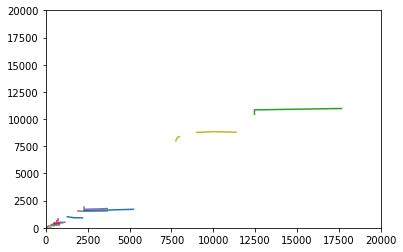

In [149]:
for pred in preds_all:
    x = pred[0]
    y = pred[1]
    plt.plot(x,y)
plt.xlim(-5, 20000)
plt.ylim(-5, 20000)
plt.show()

When I visualize the predictions, I can see that the model fails to 'increase' the predictions in line with the increase in number of cases. This may be due to the fact that many countries did not experience any significant increase in cases for a long time. The model may have learned this trait and is applying it inappopriately to countries where cases are high and increasing quickly. I think I'll train the models again on each country's series (new model each time) and capture the predictions for the real future (the next 3 days after the dataset ends). When that data is released, I can compare my predictions to the actual values.

In [150]:
pred_fut = pd.DataFrame(columns=['Country','+1 day','+2 day','+ 3day'])
preds_all_fut = []

C_i = 0
for df in series_list:
    # Extract values from the source .csv file
    y = df['y'].values.astype(float)

    # Define a test size
    test_size = 3

    # Create train and test sets
    train_set = y[:]

    # Instantiate a scaler with a feature range from -1 to 1
    scaler = MinMaxScaler(feature_range=(-1, 1))

    train_norm = scaler.fit_transform(train_set.reshape(-1, 1))


    # Convert train_norm from an array to a tensor
    train_norm = torch.FloatTensor(train_norm).view(-1)

    # Define a window size
    window_size = 5

    # Define function to create seq/label tuples


    # Apply the input_data function to train_norm
    train_data = input_data(train_norm,window_size)



    torch.manual_seed(101)
    model = LSTMnetwork()

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    epochs = 50

    import time
    start_time = time.time()

    for epoch in range(epochs):

        # extract the sequence & label from the training data
        for seq, y_train in train_data:

            # reset the parameters and hidden states
            optimizer.zero_grad()
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))

            y_pred = model(seq)

            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()

        # print training result
    

    

    future = 3

    # Add the last window of training values to the list of predictions
    preds = train_norm[-window_size:].tolist()

    # Set the model to evaluation mode
    model.eval()

    for i in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())

    true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
    print('for country ', series_dict[C_i])
    print('preds are ', true_predictions)
    preds_all_fut.append(true_predictions)
    C_i+=1

    


for country  Afghanistan
preds are  [[6.25193778]
 [5.15334058]
 [4.54157841]]
for country  Albania
preds are  [[43.16731918]
 [47.27939236]
 [44.52201694]]
for country  Algeria
preds are  [[25.88935691]
 [26.62678146]
 [26.95808697]]
for country  Andorra
preds are  [[0.99039233]
 [0.9847171 ]
 [0.97872466]]
for country  Antigua and Barbuda
preds are  [[0.07156911]
 [0.05392227]
 [0.04862383]]
for country  Argentina
preds are  [[37.63170838]
 [51.4675858 ]
 [69.26844096]]
for country  Armenia
preds are  [[11.79826069]
 [17.33729076]
 [22.68623924]]
for country  Aruba
preds are  [[0.14313823]
 [0.10784453]
 [0.09724766]]
for country  Australia
preds are  [[220.13719082]
 [279.8148632 ]
 [343.4949398 ]]
for country  Austria
preds are  [[ 766.21048737]
 [1100.54645061]
 [1382.5296936 ]]
for country  Azerbaijan
preds are  [[13.80751982]
 [14.52790082]
 [14.91141692]]
for country  Bahrain
preds are  [[226.11248463]
 [226.26569778]
 [223.9878872 ]]
for country  Bangladesh
preds are  [[2.9530

In [164]:
np.array(preds_all_fut).shape

(125, 3, 1)

In [169]:
pred_fut_df = pd.DataFrame(np.array(preds_all_fut).reshape(-1,3),columns=['+1 day','+2 day','+ 3day'])

In [171]:
pred_fut_df['Country/Region'] = Confirmed_Time['Country/Region'].unique()

In [179]:
pred_fut_df[['14/3/20','15/3/20','16/3/20']] = pred_fut_df[['+1 day','+2 day','+ 3day']].astype('int')

In [183]:
pred_fut_df = pred_fut_df.drop(['+1 day','+2 day','+ 3day'],axis = 1)

In [184]:
pred_fut_df

,Country/Region,14/3/20,15/3/20,16/3/20
0,Afghanistan,6,5,4
1,Albania,43,47,44
2,Algeria,25,26,26
3,Andorra,0,0,0
4,Antigua and Barbuda,0,0,0
5,Argentina,37,51,69
6,Armenia,11,17,22
7,Aruba,0,0,0
8,Australia,220,279,343
9,Austria,766,1100,1382


In [185]:
pred_fut_df.to_csv('Covid-19_Predictions_byCountry.csv',index=False)